In [1]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image
import torch
import os
import torch.nn as nn
import math
from ocr_label_converter import OCRLabelConverter

In [2]:
alphabet = """Only thewigsofrcvdampbkuq.$A-210xT5'MDL,RYHJ"ISPWENj&BC93VGFKz();#:!7U64Q8?+*ZX/%"""

In [3]:
# Update SynthCollator to encode labels
class SynthCollator(object):
    def __init__(self, alphabet=alphabet):
        self.converter = OCRLabelConverter(alphabet)

    def __call__(self, batch):
        width = [item['img'].shape[2] for item in batch]
        indexes = [item['idx'] for item in batch]
        imgs = torch.ones([len(batch), batch[0]['img'].shape[0], batch[0]['img'].shape[1], 
                           max(width)], dtype=torch.float32)
        for idx, item in enumerate(batch):
            try:
                imgs[idx, :, :, 0:item['img'].shape[2]] = item['img']
            except:
                print(imgs.shape)
        
        # Encode labels
        labels = [item['label'] for item in batch]
        encoded_labels, label_lengths = self.converter.encode(labels)  # Encode all labels in the batch
        
        item = {
            'img': imgs,  # (batch_size, 1, H, max_width)
            'idx': indexes,
            'label': encoded_labels,  # Tensor of encoded labels
            'label_lengths': label_lengths  # Tensor of label lengths
        }
        return item

In [4]:
#custom 
class Ocr_Dataset(Dataset):
    def __init__(self,dir ,collate_fn = None):
        self.dir = dir
        self.imgpath = os.listdir(dir)
        f = lambda x: os.path.join(self.dir, x)
        self.images_path = list(map(f,self.imgpath))
        transform_list =  [
                            transforms.RandomRotation(5), 
                            transforms.Grayscale(1),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5,), (0.5,)) 
                            ]
        self.transform = transforms.Compose(transform_list)

        
        self.collate_fn = SynthCollator()
    
    def __len__(self):
        return len(self.imgpath)
    
    def __getitem__(self, index):
        image_path = self.images_path[index]
        
        image_name = os.path.basename(image_path)
        img = Image.open(image_path)
        if self.transform is not None:
            img = self.transform(img)
            
        item = {'img':img,'idx':index}
        item["label"] = image_name.split("_")[0]
        return item
            
            
        

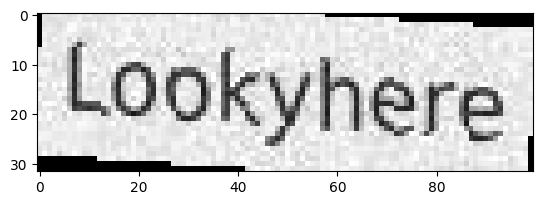

In [5]:
dir = "/home/saurav/Desktop/Get_The_Text/data/train"
import matplotlib.pyplot as plt
import numpy as np
dataset = Ocr_Dataset(dir)
len(dataset)

img = np.asarray(dataset[0]['img'])  
img = np.squeeze(img)
plt.imshow(img,cmap='gray')


In [6]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()
        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)
    def forward(self, input):
        self.rnn.flatten_parameters()
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)
        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)
        return output

class CRNN(nn.Module):

    def __init__(self, leakyRelu=False):
        super(CRNN, self).__init__()

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = 1 if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # 512x1x16
        self.cnn = cnn
        self.rnn = nn.Sequential()
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, 256, 256),
            BidirectionalLSTM(256, 256, len(alphabet)))


    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]
        # rnn features
        output = self.rnn(conv)
        output = output.transpose(1,0) #Tbh to bth
        return output

In [7]:
class CustomCTCLoss(torch.nn.Module):
    # T x B x H => Softmax on dimension 2
    def __init__(self, dim=2):
        super().__init__()
        self.dim = dim
        self.ctc_loss = torch.nn.CTCLoss(reduction='mean', zero_infinity=True)

    def forward(self, logits, labels,
            prediction_sizes, target_sizes):
        EPS = 1e-7
        loss = self.ctc_loss(logits, labels, prediction_sizes, target_sizes)
        loss = self.sanitize(loss)
        return self.debug(loss, logits, labels, prediction_sizes, target_sizes)
    
    def sanitize(self, loss):
        EPS = 1e-7
        if abs(loss.item() - float('inf')) < EPS:
            return torch.zeros_like(loss)
        if math.isnan(loss.item()):
            return torch.zeros_like(loss)
        return loss

    def debug(self, loss, logits, labels,
            prediction_sizes, target_sizes):
        if math.isnan(loss.item()):
            print("Loss:", loss)
            print("logits:", logits)
            print("labels:", labels)
            print("prediction_sizes:", prediction_sizes)
            print("target_sizes:", target_sizes)
            raise Exception("NaN loss obtained. But why?")
        return loss

In [8]:
def loss_func(logits,target,pred_size,target_size):
    return CustomCTCLoss(logits,target,pred_size,target_size)

 

In [9]:
train_dataloader = DataLoader(
    dataset=dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    collate_fn=SynthCollator()
)
for batch in train_dataloader:
    images = batch['img']  # (batch_size, 1, H, max_width)
    labels = batch['label']  # Encoded labels tensor
    label_lengths = batch['label_lengths']  # Tensor of label lengths
    print(f"Batch images shape: {images.shape}")
    print(f"Encoded labels shape: {labels.shape}")
    print(f"Label lengths: {label_lengths}")
    break

/home/saurav/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Batch images shape: torch.Size([32, 1, 32, 124])
Encoded labels shape: torch.Size([214])
Label lengths: tensor([12,  9,  3,  7,  6,  8,  4,  6,  6,  7,  9,  8,  6,  6,  4,  4,  8,  5,
         6,  4,  5,  8, 10, 11,  6,  7,  5,  9,  4,  9,  6,  6],
       dtype=torch.int32)


In [11]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = CRNN().to(device)
model.train()

# Loss and optimizer
criterion = CustomCTCLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
batch_size = 32

for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_dataloader:
        # Get the batch data
        images = batch['img'].to(device)  # (actual_batch_size, 1, H, max_width)
        labels = batch['label'].to(device)  # Encoded labels
        label_lengths = batch['label_lengths'].to(device)  # (actual_batch_size,)
        
        # Get the actual batch size from the batch
        actual_batch_size = images.shape[0]
        
        # Forward pass
        optimizer.zero_grad()
        logits = model(images)  # (actual_batch_size, T, num_classes)
        
        # CTC loss expects (T, batch_size, num_classes)
        logits = logits.transpose(0, 1)  # (T, actual_batch_size, num_classes)
        log_probs = logits.log_softmax(2)  # Apply log_softmax for CTC
        
        # Get the actual sequence length T from log_probs
        T, _, _ = log_probs.shape  # T is the actual sequence length
        prediction_sizes = torch.full((actual_batch_size,), T, dtype=torch.long).to(device)
        
        # Debugging: Ensure prediction_sizes values are valid
        if (prediction_sizes > T).any():
            raise ValueError(f"prediction_sizes contains values greater than T={T}: {prediction_sizes}")
        
        # Compute loss
        loss = criterion(log_probs, labels, prediction_sizes, label_lengths)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

Epoch [1/10], Average Loss: 2.2862
Epoch [2/10], Average Loss: 0.1431
Epoch [3/10], Average Loss: 0.0369
Epoch [4/10], Average Loss: 0.0205
Epoch [5/10], Average Loss: 0.0200
Epoch [6/10], Average Loss: 0.0116
Epoch [7/10], Average Loss: 0.0122
Epoch [8/10], Average Loss: 0.0153
Epoch [9/10], Average Loss: 0.0106
Epoch [10/10], Average Loss: 0.0083


In [24]:
torch.save(model, "ocr_model_final.pth")


In [27]:
test_model = CRNN()
test_model.load_state_dict(torch.load("ocr_model_final.pth",weights_only=True))

test_model.eval()

CRNN(
  (cnn): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU(inplace=True)
    (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU(inplace=True)
    (pooling2): MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)
    (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm4): BatchNorm2d(512, eps=1e-05, momentum=0.